In [3]:
!pip install --user pyldavis

     |████████████████████████████████| 1.4 MB 9.0 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434673 sha256=4932f45a30a99df8b6eb7655fec17681338cc73169ac537ac033b7bae8bc39a0
  Stored in directory: /home/raltman/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk


# Bag-of-words

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set()

In [3]:
data = pd.read_csv("data/lemmatized_dataset.tsv", sep='\t')

In [4]:
vec = CountVectorizer(
    stop_words='english',  # Remove common uninformative words
    ngram_range=(1, 2),  # Include bigrams
    min_df=10,  # Remove words that appear in <10 documents
    max_df=0.2  # Remove words that appear in >20% of documents
)
X = vec.fit_transform(data.text)

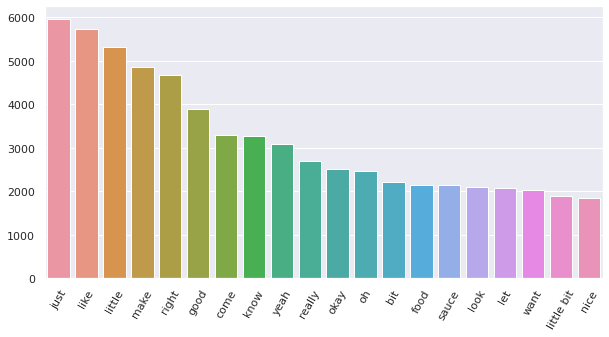

In [5]:
n = 20

values = X.toarray().sum(axis=0)
labels = np.array(vec.get_feature_names())
top_n = values.argsort()[:-n-1:-1]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(labels[top_n], values[top_n], ax=ax)
_ = ax.set_xticklabels(labels[top_n], rotation=60)

# Latent Dirichlet Allocation

<img src="imgs/lda1.png">

In [6]:
import numpy as np
from tqdm import tqdm
from textwrap import fill
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import MDS

tqdm.pandas()

In [7]:
lda = LDA(n_components=3, n_jobs=-1)
X_lda = lda.fit_transform(X)

100%|██████████| 650/650 [00:12<00:00, 52.42it/s]


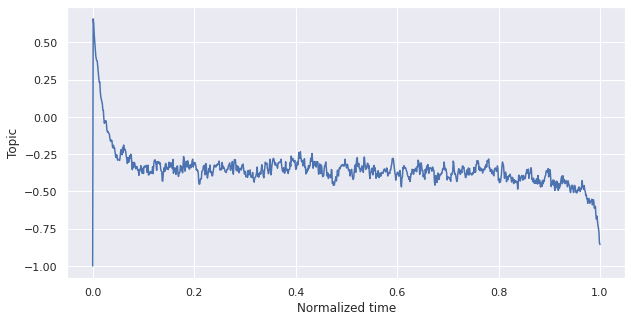

In [8]:
def time_series_topics(group):
    topics = np.zeros_like(times) - 1
    for idx, row in group.iterrows():
        start = row.start / row.duration
        end = row.end / row.duration
        topics[(start<times) & (times<=end)] = row.topic
    return topics

data_topics = data.assign(topic=X_lda.argmax(axis=1))

times = np.linspace(0, 1, int(1e3))
data_topics_ts = data_topics.groupby('name').progress_apply(time_series_topics)

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(times, data_topics_ts.mean(), ax=ax)
_ = ax.set_xlabel("Normalized time")
_ = ax.set_ylabel("Topic")

In [9]:
topic_word_probs = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
doc_topic_probs = X_lda / X_lda.sum(axis=1, keepdims=True)

In [10]:
def top_n_topic_docs(n: int = 1):
    top_n = doc_topic_probs.argsort(axis=0)[:-n-1:-1].T
    return np.vectorize(data.text.__getitem__)(top_n)

In [11]:
distance_matrix = squareform(pdist(topic_word_probs, metric='jensenshannon'))
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(distance_matrix)

In [12]:
topic_freq = (X_lda.T * X.sum(axis=1)).A.squeeze()
topic_freq /= topic_freq.sum()

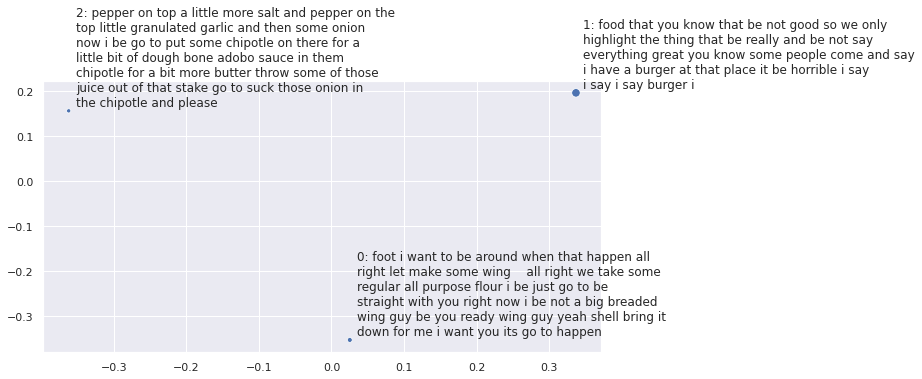

In [13]:
topic_reps = top_n_topic_docs()[:, 0]
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(*X_mds.T, size=1e4*topic_freq, legend=False, ax=ax)
for i, ((x, y), text) in enumerate(zip(X_mds, topic_reps)):
    ax.text(x+.01, y+.01, f"{i}: {fill(text, 50)}")

In [14]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [15]:
pyLDAvis.sklearn.prepare(lda, X, vec, mds='mmds', n_jobs=-1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.249082  0.089073       1        1  36.509556
0     -0.009155 -0.215626       2        1  32.026922
2     -0.239928  0.126553       3        1  31.463522, topic_info=        Term         Freq        Total Category  logprob  loglift
2392    just  5892.000000  5892.000000  Default  30.0000  30.0000
2794  little  5312.000000  5312.000000  Default  29.0000  29.0000
4157   right  4632.000000  4632.000000  Default  28.0000  28.0000
1853    good  3780.000000  3780.000000  Default  27.0000  27.0000
319      bit  2212.000000  2212.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
5265     use   637.788361  1079.281502   Topic3  -5.2573   0.6303
3416      oh   827.988076  2435.359099   Topic3  -4.9963   0.0775
2983    make   980.227071  4795.043763   Topic3  -4.8276  -0.4312
683   cheese   657.250709  1602.971203   Topic3  -5.2273   0.2648
1581  flavor   583.812376  1499.105427   Topic3  -5.3458   0.2133

[235 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
21        2  0.047209      add
21        3  0.952461      add
96        2  0.988673  angeles
191       2  0.995838     bake
252       3  0.996742     bean
...     ...       ...      ...
5554      1  0.029023      yes
5554      2  0.700832      yes
5554      3  0.269748      yes
5565      2  0.995842  yes sir
5576      1  0.991766     york

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])